In [91]:
import pandas as pd
import seaborn as sns
from scipy.special import jv

In [5]:
df = pd.DataFrame(pd.read_pickle('../../simulation_log.pkl'))

In [423]:
steps = np.arange(2000,2700,10)

In [ ]:
single_step = df.query("step == 2721")

,time,step,x_world,y_world,cell_unique_id,identity
3462650,27.21,2721,873.689867,287.151507,0,0
3462651,27.21,2721,881.440951,268.959902,0,0
3462652,27.21,2721,882.256802,248.222192,0,0
3462653,27.21,2721,875.477305,227.223142,0,0
3462654,27.21,2721,862.252687,209.424990,0,0
...,...,...,...,...,...,...
3465495,27.21,2721,1148.622588,426.059332,56,1
3465496,27.21,2721,1155.478537,423.710997,56,1
3465497,27.21,2721,1161.636949,420.328392,56,1
3465498,27.21,2721,1167.182133,415.544068,56,1


In [9]:
import matplotlib.pyplot as plt

In [41]:
from skimage import draw
import numpy as np

# Get the bounds of the data to define raster size
x_min, x_max = single_step['x_world'].min(), single_step['x_world'].max()
y_min, y_max = single_step['y_world'].min(), single_step['y_world'].max()

# Define raster resolution (adjust as needed)
width, height = 1000, 1000

# Create empty raster
raster = np.zeros((height, width), dtype=int)

# Convert world coordinates to raster coordinates
def world_to_raster(x, y):
    col = ((x - x_min) / (x_max - x_min) * (width - 1)).astype(int)
    row = ((y_max - y) / (y_max - y_min) * (height - 1)).astype(int)
    return row, col

#
def split_wrapped_polygon(x_coords, y_coords, x_domain, y_domain):
    """Split a wrapped polygon into multiple non-wrapped segments"""
    segments = []
    
    # Detect large jumps that indicate wrapping
    x_diff = np.abs(np.diff(x_coords))
    y_diff = np.abs(np.diff(y_coords))
    
    x_wrap_threshold = x_domain * 0.5
    y_wrap_threshold = y_domain * 0.5
    
    # Find wrap points
    x_wraps = x_diff > x_wrap_threshold
    y_wraps = y_diff > y_wrap_threshold
    wrap_points = np.where(x_wraps | y_wraps)[0] + 1
    
    if len(wrap_points) == 0:
        # No wrapping detected
        return [(x_coords, y_coords)]
    
    # Split at wrap points
    start_idx = 0
    for wrap_idx in wrap_points:
        if wrap_idx > start_idx:
            segments.append((x_coords[start_idx:wrap_idx], y_coords[start_idx:wrap_idx]))
        start_idx = wrap_idx
    
    # Add final segment
    if start_idx < len(x_coords):
        segments.append((x_coords[start_idx:], y_coords[start_idx:]))
    
    return segments

# Rasterize each cell (only identity == 1)
for cell_id in single_step['cell_unique_id'].unique():
    # Filter for identity == 1 only
    cell_data = single_step[(single_step['cell_unique_id'] == cell_id) & (single_step['identity'] == 0)]
    
    if len(cell_data) < 3:  # Need at least 3 points for a polygon
        continue
    
    # Sort points by angle to maintain polygon structure
    center_x = np.mean(cell_data['x_world'].values)
    center_y = np.mean(cell_data['y_world'].values)
    
    angles = np.arctan2(cell_data['y_world'].values - center_y, 
                       cell_data['x_world'].values - center_x)
    sort_idx = np.argsort(angles)
    
    sorted_x = cell_data['x_world'].values[sort_idx]
    sorted_y = cell_data['y_world'].values[sort_idx]
    
    # Split polygon if it wraps around boundaries
    x_domain = x_max - x_min
    y_domain = y_max - y_min
    segments = split_wrapped_polygon(sorted_x, sorted_y, x_domain, y_domain)
    
    # Rasterize each segment
    for seg_x, seg_y in segments:
        if len(seg_x) >= 3:  # Need at least 3 points for a polygon
            # Convert to raster coordinates
            seg_rows, seg_cols = world_to_raster(seg_x, seg_y)
            
            # Clip to raster bounds
            seg_rows = np.clip(seg_rows, 0, height - 1)
            seg_cols = np.clip(seg_cols, 0, width - 1)
            
            try:
                rr, cc = draw.polygon(seg_rows, seg_cols, shape=(height, width))
                raster[rr, cc] = cell_id + 1
            except:
                # Fallback: draw individual points if polygon fails
                valid_mask = (seg_rows >= 0) & (seg_rows < height) & (seg_cols >= 0) & (seg_cols < width)
                if np.any(valid_mask):
                    raster[seg_rows[valid_mask], seg_cols[valid_mask]] = cell_id + 1

In [44]:
from skimage import draw
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, LineString, box
from shapely.ops import split, unary_union
from shapely.affinity import translate

DEFAULT_WIDTH = 1500
DEFAULT_HEIGHT = 1000

# Get the bounds of the data to define raster size
# Use the known screen dimensions for wrapping logic
x_min, x_max = 0, DEFAULT_WIDTH
y_min, y_max = 0, DEFAULT_HEIGHT

# Define raster resolution (adjust as needed)DTH, DEFAULT_HEIGHT
width, height = DEFAULT_WIDTH, DEFAULT_HEIGHT


# Convert world coordinates to raster coordinates
def world_to_raster(x, y):
    # Assuming the raster maps directly to the world coordinates for simplicity
    col = (x / x_max * (width - 1)).astype(int)
    row = (y / y_max * (height - 1)).astype(int)
    # Invert y-axis for typical image coordinate systems (origin top-left)
    row = (height - 1) - row
    return row, col

def handle_wrapped_polygon(x_coords, y_coords):
    """
    Handles wrapped polygons by splitting them at the boundaries
    and returning a list of drawable polygon coordinates.
    """
    # Create a Shapely Polygon
    # The polygon is assumed to be "unwrapped" into a large continuous space first
    unwrapped_x = np.copy(x_coords).astype(float)
    unwrapped_y = np.copy(y_coords).astype(float)

    # Detect and correct wraps for x coordinates
    x_diffs = np.diff(unwrapped_x)
    x_wrap_threshold = DEFAULT_WIDTH * 0.8
    x_wraps = np.where(np.abs(x_diffs) > x_wrap_threshold)[0]
    for idx in x_wraps:
        if x_diffs[idx] > 0: # Wrap from left to right (e.g., 10 -> 1490)
            unwrapped_x[idx+1:] -= DEFAULT_WIDTH
        else: # Wrap from right to left (e.g., 1490 -> 10)
            unwrapped_x[idx+1:] += DEFAULT_WIDTH

    # Detect and correct wraps for y coordinates
    y_diffs = np.diff(unwrapped_y)
    y_wrap_threshold = DEFAULT_HEIGHT * 0.8
    y_wraps = np.where(np.abs(y_diffs) > y_wrap_threshold)[0]
    for idx in y_wraps:
        if y_diffs[idx] > 0: # Wrap from bottom to top
            unwrapped_y[idx+1:] -= DEFAULT_HEIGHT
        else: # Wrap from top to bottom
            unwrapped_y[idx+1:] += DEFAULT_HEIGHT

    unwrapped_poly = Polygon(zip(unwrapped_x, unwrapped_y))
    if not unwrapped_poly.is_valid:
        unwrapped_poly = unwrapped_poly.buffer(0)
    if unwrapped_poly.is_empty:
        return []

    # Define the screen boundary
    screen_box = box(0, 0, DEFAULT_WIDTH, DEFAULT_HEIGHT)
    
    # Find all pieces of the polygon by translating it and intersecting with the screen
    min_uw_x, min_uw_y, max_uw_x, max_uw_y = unwrapped_poly.bounds
    
    # Determine the tile range needed to cover the polygon
    i_start = int(np.floor(min_uw_x / DEFAULT_WIDTH))
    i_end = int(np.ceil(max_uw_x / DEFAULT_WIDTH))
    j_start = int(np.floor(min_uw_y / DEFAULT_HEIGHT))
    j_end = int(np.ceil(max_uw_y / DEFAULT_HEIGHT))

    polygons = []
    for i in range(i_start, i_end):
        for j in range(j_start, j_end):
            # Translate the unwrapped polygon to a potential screen location
            translated_poly = translate(unwrapped_poly, xoff=-i * DEFAULT_WIDTH, yoff=-j * DEFAULT_HEIGHT)
            
            # Find the part of the translated polygon that is inside the screen
            intersection = translated_poly.intersection(screen_box)
            
            if not intersection.is_empty:
                if isinstance(intersection, Polygon):
                    polygons.append(intersection)
                elif isinstance(intersection, MultiPolygon):
                    polygons.extend(list(intersection.geoms))

    # The union operation can merge overlapping or touching polygons, simplifying the result.
    # This is useful if the tiling process creates redundant or fragmented geometries.
    if not polygons:
        return []
        
    final_polygons = unary_union(polygons)
    if isinstance(final_polygons, Polygon):
        return [final_polygons]
    elif isinstance(final_polygons, MultiPolygon):
        return list(final_polygons.geoms)
    else:
        return []

frame_pairs = []
frame_pair = []
for type in [0,1]:
    # Create empty raster
    raster = np.zeros((height, width), dtype=int)
    # Rasterize each cell (only identity == 0)
    for cell_id in single_step['cell_unique_id'].unique():
        cell_data = single_step[(single_step['cell_unique_id'] == cell_id) & (single_step['identity'] == type)]
        
        if len(cell_data) < 3:
            continue
        
        # Sort points by angle to form a contiguous boundary
        # A robust centroid calculation is important for complex shapes
        # Using the mean of coordinates is simple but can be skewed.
        # For convex-like shapes, it's usually sufficient.
        center_x = np.mean(cell_data['x_world'].values)
        center_y = np.mean(cell_data['y_world'].values)
        angles = np.arctan2(cell_data['y_world'].values - center_y, cell_data['x_world'].values - center_x)
        sort_idx = np.argsort(angles)
        
        sorted_x = cell_data['x_world'].values[sort_idx]
        sorted_y = cell_data['y_world'].values[sort_idx]

        # Handle wrapped polygons and get a list of drawable polygons
        drawable_polygons = handle_wrapped_polygon(sorted_x, sorted_y)

        # Rasterize each resulting polygon
        for poly in drawable_polygons:
            if poly.is_empty or not isinstance(poly, Polygon) or len(poly.exterior.coords) < 3:
                continue

            poly_x, poly_y = poly.exterior.xy
            
            # Convert to raster coordinates
            rows, cols = world_to_raster(np.array(poly_x), np.array(poly_y))
            
            # Clip to raster bounds to be safe
            rows = np.clip(rows, 0, height - 1)
            cols = np.clip(cols, 0, width - 1)
            
            try:
                rr, cc = draw.polygon(rows, cols, shape=(height, width))
                raster[rr, cc] = cell_id + 1
            except Exception as e:
                # Fallback for any drawing errors
                print(f"Could not draw polygon for cell {cell_id}. Error: {e}")
                # As a fallback, draw the polygon outline
                rr_line, cc_line = draw.polygon_perimeter(rows, cols, shape=(height, width))
                raster[rr_line, cc_line] = cell_id + 1

    frame_pair.append(raster)
frame_pairs.append(frame_pair)


In [197]:
class Camera:
    """
    Class for instantiating Camera objects.

    Example:

    >>> my_camera = Camera(baseline=100, sensitivity=2.9, dark_noise=8)
    >>> my_camera.render_dark_image()

    """

    def __init__(self, baseline, sensitivity, dark_noise):
        """

        :param int baseline: The baseline intensity of the camera.
        :param float sensitivity: The camera sensitivity.
        :param dark_noise: The camera dark noise
        """
        self.baseline, self.sensitivity, self.dark_noise = baseline, sensitivity, dark_noise

    def render_dark_image(self, size, plot=True):
        """
        Render a sample synthetic dark image from the camera

        :param tuple(int, int) size: Size of the dark image.
        :param bool plot: Whether or not to plot the image.
        :return: Dark image sample.
        :rtype: np.ndarray
        """
        rng = np.random.default_rng(2)
        dark_img = rng.normal(loc=self.baseline, scale=self.dark_noise, size=size)
        dark_img = rng.poisson(dark_img)
        if plot:
            plt.imshow(dark_img, cmap="Greys_r")
            plt.colorbar()
            plt.axis("off")
            plt.show()
        return dark_img



In [198]:
import matplotlib.pyplot as plt

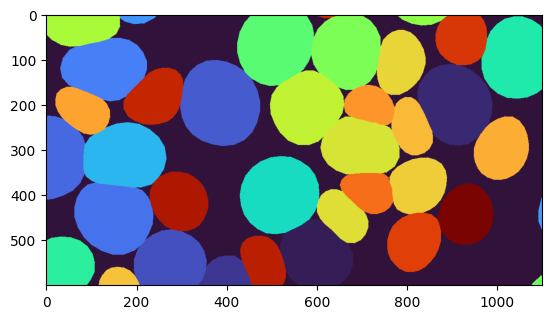

In [199]:
plt.imshow(frame_pairs[0][0][200:-200,200:-200], cmap="turbo")

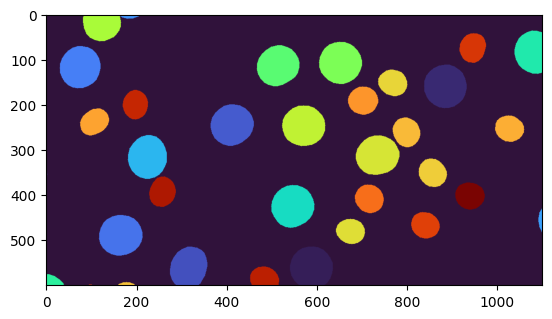

In [200]:
plt.imshow(frame_pairs[0][1][200:-200,200:-200], cmap="turbo")

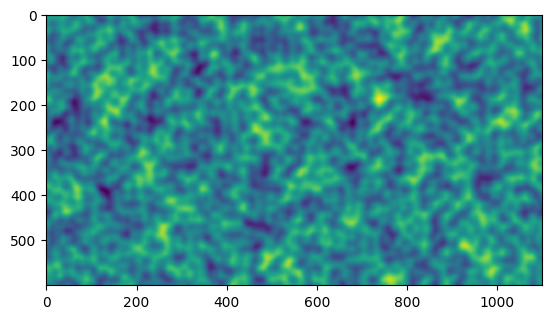

In [201]:
import noise
import numpy as np

shape = (bg.shape[0], bg.shape[1])
scale = 100.0
octaves = 3
persistence = 1
lacunarity = 2.0
base = 0

world = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world[i][j] = noise.pnoise2(i / scale, 
                                    j / scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity, 
                                    repeatx=shape[0], 
                                    repeaty=shape[1], 
                                    base=base)
world = world - world.min()
plt.imshow(world)

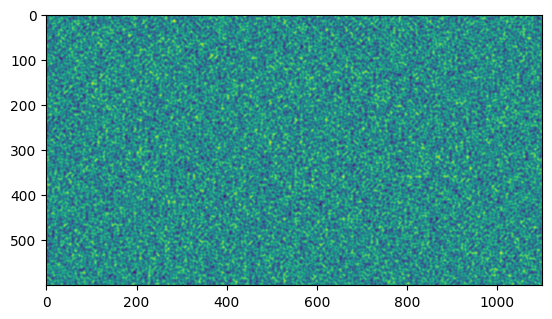

In [202]:
import noise
import numpy as np

shape = (bg.shape[0], bg.shape[1])
scale = 100.0
octaves = 5
persistence = 2
lacunarity = 2.0
base = 0

world2 = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world2[i][j] = noise.pnoise2(i / scale, 
                                    j / scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity, 
                                    repeatx=shape[0], 
                                    repeaty=shape[1], 
                                    base=base)
world2 = world2 - world2.min()
plt.imshow(world2)

In [203]:
from scipy.ndimage import distance_transform_edt

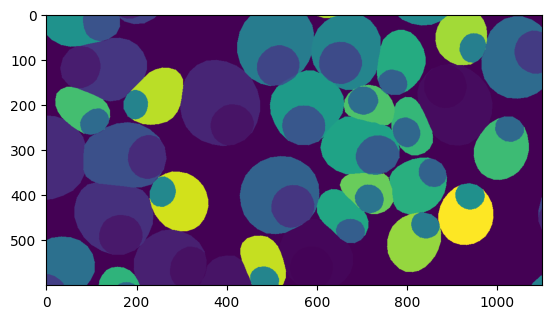

In [345]:
plt.imshow(cyto)

In [367]:
test =  (((cyto == 2) > 0) - (0.5 * ((nuclei == 2 ) > 0))) 

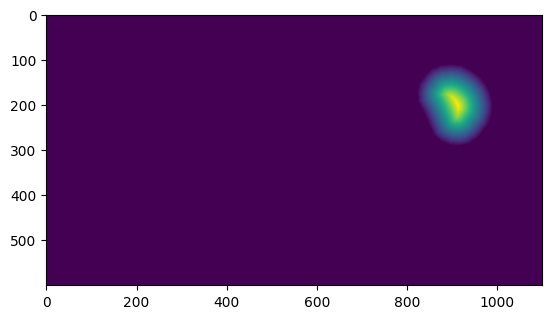

In [368]:
plt.imshow(distance_transform_edt(test))

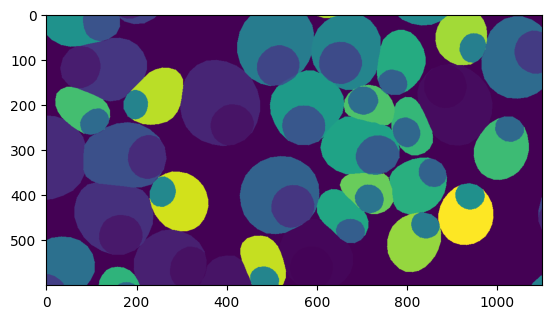

In [344]:
plt.imshow(cyto)

In [388]:
bg = np.zeros_like(frame_pairs[0][0][200:-200,200:-200], dtype=np.float32)
bg += 150
nuclei = frame_pairs[0][1][200:-200,200:-200]
cyto = frame_pairs[0][0][200:-200,200:-200]
edt = distance_transform_edt(nuclei> 0)
edt = edt/edt.max()

cyto_edt = np.zeros_like(cyto, dtype=np.float32)
for mask_id in np.unique(cyto)[1:]:
    dt = distance_transform_edt((cyto == mask_id) > 0)
    dt = distance_transform_edt(dt)** (1/2)
    dt -= ((nuclei == mask_id) > 0) * 4
    cyto_edt += dt

cyto_edt = (cyto_edt ) +  (cyto > 0) * 10
cyto_edt /= 2
cyto_channel = bg + cyto_edt * world2 * 120 
nuclei_channel = bg + (edt * world  * 2200)

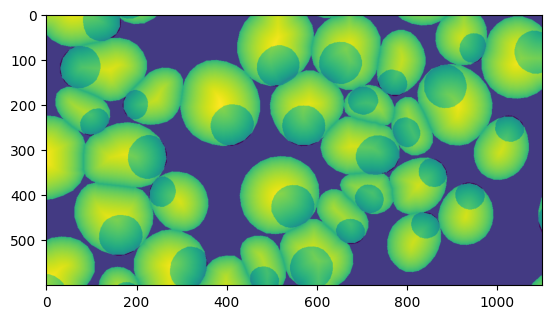

In [389]:
plt.imshow(cyto_edt)

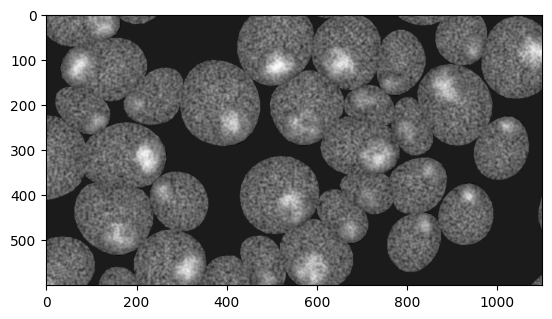

In [392]:
plt.imshow(nuclei_channel + cyto_channel, cmap="Greys_r")

In [393]:
def get_fluorescence_kernel(wavelength, NA, n, radius, scale, offset=0):
    """
    Returns a 2D numpy array which is an airy-disk approximation of the fluorescence point spread function

    Parameters
    ----------
    Lambda : float
        Wavelength of imaging light (micron)
    NA : float
        Numerical aperture of the objective lens
    n : float
        Refractive index of the imaging medium (~1 for air, ~1.4-1.5 for oil)
    radius : int
        The radius of the PSF to be rendered in pixels
    scale : float
        The pixel size of the image to be rendered (micron/pix)
    offset : float
        A constant offset to add to the PSF, increases accuracy of long range effects, especially useful for colony simulations.

    Returns
    -------
    2-D numpy array representing the fluorescence contrast PSF
    """

    r = np.arange(-radius, radius + 1)
    kaw = 2 * NA / n * np.pi / wavelength  # np.tan(np.arcsin(NA/n))
    xx, yy = np.meshgrid(r, r)
    xx, yy = xx * scale, yy * scale
    rr = np.sqrt(xx**2 + yy**2) * kaw
    PSF = (2 * jv(1, rr) / (rr)) ** 2
    PSF[radius, radius] = 1
    PSF += offset
    return PSF

/var/folders/q1/qs95q2qs04ldzxl9b5nxjx2c0000gn/T/ipykernel_40446/4143612587.py:30: RuntimeWarning: invalid value encountered in divide
  PSF = (2 * jv(1, rr) / (rr)) ** 2


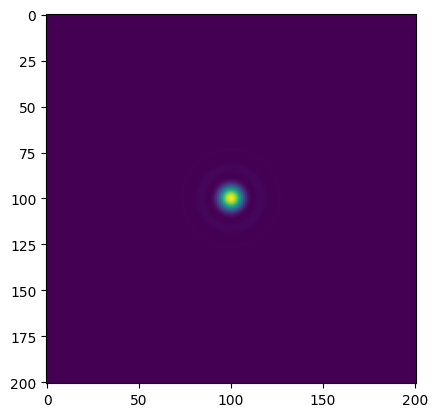

In [394]:
pixel_size = 8 / 250
wavelength = 0.6
NA = 0.95
n = 1
radius = 100
PSF = get_fluorescence_kernel(wavelength, NA, n, radius, pixel_size)
plt.imshow(PSF)

pixel_size = 8 / 250
wavelength = 0.7
NA = 0.95
n = 1
radius = 100
PSF_cyto = get_fluorescence_kernel(wavelength, NA, n, radius, pixel_size)
plt.imshow(PSF)

In [395]:
from scipy.signal import fftconvolve

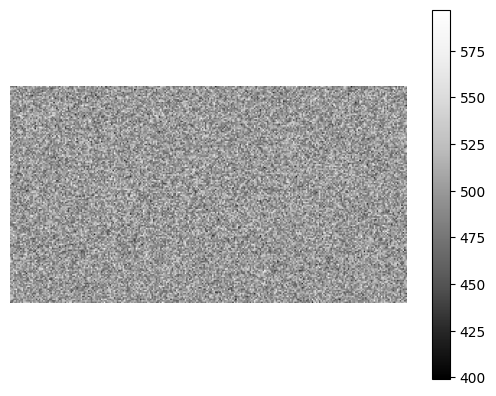

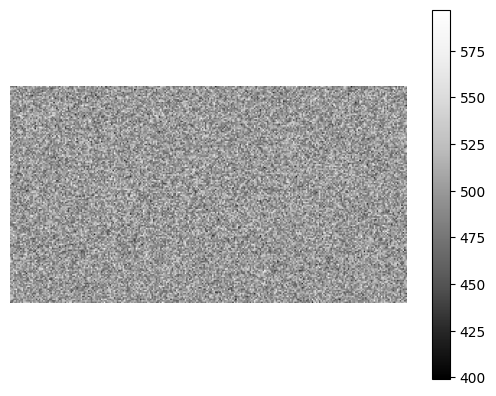

In [396]:
my_camera = Camera(baseline=500, sensitivity=2.9, dark_noise=8)
dark_image = my_camera.render_dark_image(size = nuclei_channel[::4,::4].shape)
dark_image_2 = my_camera.render_dark_image(size = nuclei_channel[::4,::4].shape)


In [397]:
nuclei_image  = fftconvolve(nuclei_channel, PSF, mode="same")[::4,::4] + dark_image
cyto_image  = fftconvolve(cyto_channel, PSF_cyto, mode="same")[::4,::4] + dark_image_2

In [398]:
from microfilm import microplot

In [407]:
multi_channel = np.array([nuclei_image, cyto_image])

In [412]:
nuclei_image.min()

np.float64(5903.679085051312)

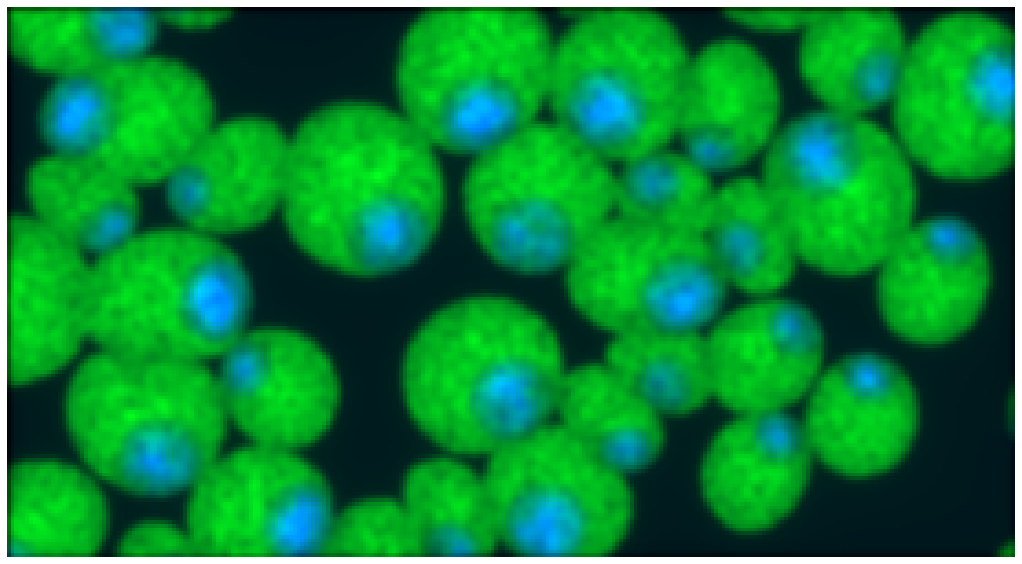

In [416]:
microim = microplot.microshow(images=multi_channel, fig_scaling=14, cmaps=["blue", "green"], rescale_type='limits',limits=[(nuclei_image.min(),nuclei_image.max()/1.5), (cyto_image.min(), cyto_image.max())])

In [417]:
microim.savefig("test.png")